In [24]:
import cv2
import glob
import pandas as pd
from imageio import imread,imsave
from skimage.transform import resize
from tqdm import tqdm
import dlib


train_paths = glob.glob("./images/*")
#print(train_paths)

df_train = pd.DataFrame(columns=['image', 'label', 'name'])

for i,train_path in tqdm(enumerate(train_paths)):
    name = train_path.split("\\")[-1]
    images = glob.glob(train_path + "/*")
    for image in images:
        df_train.loc[len(df_train)]=[image,i,name]
        
#print(df_train)
        
for img_path in df_train.image:
    print(img_path)
    image = imread(img_path)
    hogFaceDetector = dlib.get_frontal_face_detector()
    faceRects = hogFaceDetector(image, 0)

    for (i,faceRect) in enumerate( faceRects):
        if (faceRect==None):
            continue
    
        x1 = faceRect.left()
        y1 = faceRect.top()
        x2 = faceRect.right()
        y2 = faceRect.bottom()

        face = image[y1:y2,x1:x2]
        imsave(img_path,face)
    

4it [00:00, 38.60it/s]

['./images\\Anne_Hathaway', './images\\Ayushmann_Khurrana', './images\\Brad_Pitt', './images\\Irrfan_Khan', './images\\Jen_Aniston', './images\\Jen_Lawrence', './images\\Johnny_Depp', './images\\Pankaj_Tripathi', './images\\Robert_DowneyJr', './images\\Will_Smith']


10it [00:00, 31.97it/s]


                                image label                name
0        ./images\Anne_Hathaway\1.jpg     0       Anne_Hathaway
1        ./images\Anne_Hathaway\2.jpg     0       Anne_Hathaway
2        ./images\Anne_Hathaway\3.jpg     0       Anne_Hathaway
3   ./images\Ayushmann_Khurrana\4.jpg     1  Ayushmann_Khurrana
4   ./images\Ayushmann_Khurrana\5.jpg     1  Ayushmann_Khurrana
5   ./images\Ayushmann_Khurrana\6.jpg     1  Ayushmann_Khurrana
6           ./images\Brad_Pitt\10.jpg     2           Brad_Pitt
7            ./images\Brad_Pitt\7.jpg     2           Brad_Pitt
8            ./images\Brad_Pitt\8.jpg     2           Brad_Pitt
9            ./images\Brad_Pitt\9.jpg     2           Brad_Pitt
10        ./images\Irrfan_Khan\11.jpg     3         Irrfan_Khan
11        ./images\Irrfan_Khan\12.jpg     3         Irrfan_Khan
12        ./images\Irrfan_Khan\13.jpg     3         Irrfan_Khan
13        ./images\Irrfan_Khan\14.jpg     3         Irrfan_Khan
14        ./images\Irrfan_Khan\15.jpg   

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_323 (ZeroPadding (None, 102, 102, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_323[0][0]         
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

0it [00:00, ?it/s]
0it [00:00, ?it/s]

[]
Empty DataFrame
Columns: [image, label, name]
Index: []


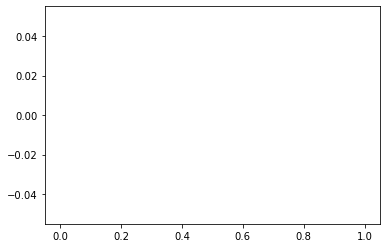

['./Test\\ah1.jpg', './Test\\ah2.jpg', './Test\\rdj1.jpg']
len(faces) = 1


ValueError: zero-size array to reduction operation minimum which has no identity

In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from scipy.spatial import distance
from keras.models import load_model
import pandas as pd
from tqdm import tqdm
import dlib
from model import *
from align import AlignDlib
import glob
import imutils


# INITIALIZE MODELS
nn4_small2 = create_model()

nn4_small2.summary()

nn4_small2.load_weights('./weights/nn4.small2.v1.h5')

alignment = AlignDlib('./shape_predictor_68_face_landmarks.dat')

#LOAD TRAINING INFORMATION
train_paths = glob.glob("image/*")
print(train_paths)

nb_classes = len(train_paths)

df_train = pd.DataFrame(columns=['image', 'label', 'name'])

for i,train_path in enumerate(train_paths):
    name = train_path.split("\\")[-1]
    images = glob.glob(train_path + "/*")
    for image in images:
        df_train.loc[len(df_train)]=[image,i,name]
        
print(df_train.head())

# PRE-PROCESSING
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def align_face(face):
    #print(img.shape)
    (h,w,c) = face.shape
    bb = dlib.rectangle(0, 0, w, h)
    #print(bb)
    return alignment.align(96, face, bb,landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  
def load_and_align_images(filepaths):
    aligned_images = []
    for filepath in filepaths:
        #print(filepath)
        img = cv2.imread(filepath)
        aligned = align_face(img)
        aligned = (aligned / 255.).astype(np.float32)
        aligned = np.expand_dims(aligned, axis=0)
        aligned_images.append(aligned)
            
    return np.array(aligned_images)
    
def calc_embs(filepaths, batch_size=64):
    pd = []
    for start in tqdm(range(0, len(filepaths), batch_size)):
        aligned_images = load_and_align_images(filepaths[start:start+batch_size])
        pd.append(nn4_small2.predict_on_batch(np.squeeze(aligned_images)))
    #embs = l2_normalize(np.concatenate(pd))
    embs = np.array(pd)

    return np.array(embs)
    
def align_faces(faces):
    aligned_images = []
    for face in faces:
        #print(face.shape)
        aligned = align_face(face)
        aligned = (aligned / 255.).astype(np.float32)
        aligned = np.expand_dims(aligned, axis=0)
        aligned_images.append(aligned)
        
    return aligned_images

def calc_emb_test(faces):
    pd = []
    aligned_faces = align_faces(faces)
    if(len(faces)==1):
        pd.append(nn4_small2.predict_on_batch(aligned_faces))
    elif(len(faces)>1):
        pd.append(nn4_small2.predict_on_batch(np.squeeze(aligned_faces)))
    #embs = l2_normalize(np.concatenate(pd))
    embs = np.array(pd)
    return np.array(embs)

# TRAINING
label2idx = []

for i in tqdm(range(len(train_paths))):
    label2idx.append(np.asarray(df_train[df_train.label == i].index))

train_embs = calc_embs(df_train.image)
np.save("train_embs.npy", train_embs)

#train_embs = np.concatenate(train_embs)



In [ ]:
# ANALYSING
import matplotlib.pyplot as plt

match_distances = []
for i in range(nb_classes):
    ids = label2idx[i]
    distances = []
    for j in range(len(ids) - 1):
        for k in range(j + 1, len(ids)):
            distances.append(distance.euclidean(train_embs[ids[j]].reshape(-1), train_embs[ids[k]].reshape(-1)))
    match_distances.extend(distances)
    
unmatch_distances = []
for i in range(nb_classes):
    ids = label2idx[i]
    distances = []
    for j in range(10):
        idx = np.random.randint(train_embs.shape[0])
        while idx in label2idx[i]:
            idx = np.random.randint(train_embs.shape[0])
        distances.append(distance.euclidean(train_embs[ids[np.random.randint(len(ids))]].reshape(-1), train_embs[idx].reshape(-1)))
    unmatch_distances.extend(distances)
    
_,_,_=plt.hist(match_distances,bins=100)
_,_,_=plt.hist(unmatch_distances,bins=100,fc=(1, 0, 0, 0.5))

plt.show()

threshold = 1

In [ ]:
# TEST
test_paths = glob.glob("./Test/*")
print(test_paths)
        
for path in test_paths:
    test_image = cv2.imread(path)
    show_image = test_image.copy()

    hogFaceDetector = dlib.get_frontal_face_detector()
    faceRects = hogFaceDetector(test_image, 0)
    
    faces = []
    
    for faceRect in faceRects:
        x1 = faceRect.left()
        y1 = faceRect.top()
        x2 = faceRect.right()
        y2 = faceRect.bottom()
        face = test_image[y1:y2,x1:x2]
        
        faces.append(face)

    print("len(faces) = {0}".format(len(faces)))
    if(len(faces)==0):
        print("no face detected!")
        continue
    else:    
        test_embs = calc_emb_test(faces)

    test_embs = np.concatenate(test_embs)
        
    people = []
    for i in range(test_embs.shape[0]):
        distances = []
        for j in range(len(train_paths)):
            distances.append(np.min([distance.euclidean(test_embs[i].reshape(-1), train_embs[k].reshape(-1)) for k in label2idx[j]]))
            for k in label2idx[j]:
                print(distance.euclidean(test_embs[i].reshape(-1), train_embs[k].reshape(-1)))
        if np.min(distances)>threshold:
            people.append("unknown")
        else:
            res = np.argsort(distances)[:1]
            people.append(res)

    names = []
    title = ""
    for p in people:
        if p == "unknown":
            name = "unknown"
        else:
            name = df_train[(df_train['label']==p[0])].name.iloc[0]
        names.append(name)
        title = title + name + " "
        
    for i,faceRect in enumerate(faceRects):
        x1 = faceRect.left()
        y1 = faceRect.top()
        x2 = faceRect.right()
        y2 = faceRect.bottom()
        cv2.rectangle(show_image,(x1,y1),(x2,y2),(255,0,0),3)
        cv2.putText(show_image,names[i],(x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),3,cv2.LINE_AA)
        

    show_image = imutils.resize(show_image,width = 720)   
    cv2.imshow("result",show_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()